# 6.2 순환 신경망 이해하기

### 순환 신경망

- **순환 신경망(Recurrent Neural Network, RNN)**은 시퀀스의 원소를 순회하면서 처리한 정보를 **상태(state)**에 저장하는 신경망의 한 종류
- 내부에 루프(loop)를 가지고 있어서 시퀀스의 원소를 차례대로 방문
- 하나의 시퀀스가 하나의 데이터 포인트로 간주되며 이 데이터 포인트가 한번에 처리되지 않음(loop가 있어서)


#### 피드포워드 네트워크(feedforward network)

- RNN과 달리 Fully Connected Network나 Convnet은 메모리가 없으며 입력간에 유지되는 상태가 없음(입력은 개별적으로 처리됨)
- 이런 네트워크에서 시퀀스나 시계열 데이터 포인트를 처리하려면 전체 시퀀스를 하나의 데이터 포인트로 변환해야 함
- 이런 네트워크를 **피드포워드 네트워크(feedforward network)**라고 함


### RNN의 동작

1. 크기가 `(timesteps, input_features)`인 2D 텐서 형태로 시퀀스를 입력 받음
    - 임베딩 층의 출력이 입력으로 들어온다고 생각하면 (단어 길이, 임베딩 벡터 차원)이라고 볼 수 있음 `(maxlen, embedding_dimensionality)`
    
    
2. 시퀀스는 `timesteps`동안 아래의 과정을 반복함
    - 현재 상태(`state_t`)와 입력(`input_t`)을 연결하여 출력을 계산
    - 이 출력을 다음 `timestep`의 상태(`state_t`)로 설정


    위의 2 과정을 pseudo code로 표현하면 다음과 같음

~~~
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t
~~~

1. 상태와 입력을 받아 출력하는 함수 f는 activation function으로 볼 수 있음


2. 입력과 상태를 출력으로 변환하는 연산은 2개의 행렬 W와 U 그리고 bias 벡터를 사용하는 변환으로 바꿀 수 있음(완전 연결 층의 변환과 유사)


    위 두 항목을 적용해 다시 pseudo code로 나타내면 다음과 같음

~~~
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t), dot(U, state_t) + b)
    state_t = output_t
~~~

In [1]:
# 넘파이로 간단한 RNN 구현

# input_sequence = (timesteps, input_features)
# output_sequence = (timesteps, input_features)

import numpy as np

timesteps = 100
input_features = 32
output_features = 64

input_sequence = np.random.random((timesteps, input_features))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features))

output_sequence = []

state_t = np.random.random((output_features))

for input_t in input_sequence:
    # activation function을 여기선 tanh를 사용(케라스 SimpleRNN의 기본값은 tanh)
    output_t = np.tanh(np.dot(W, input_t)+np.dot(U, state_t)+b)
    output_sequence.append(output_t)
    
    state_t = output_t
    
# 아래 3개 결과 다 똑같음
# output_sequence = np.array(output_sequence)
# output_sequence = np.vstack(output_sequence)
output_sequence = np.stack(output_sequence, axis=0)


print("입력 크기 :", input_sequence.shape)
print("출력 크기 :", output_sequence.shape)

입력 크기 : (100, 32)
출력 크기 : (100, 64)


## 6.2.1 케라스의 순환 층

### 케라스의 SimpleRNN

- 앞서 간단히 구현한 넘파이 예제가 실제 케라스의 SimpleRNN층의 동작 방식
- 케라스의 SimpleRNN은 batch 단위로 시퀀스를 처리한다는 점만 다름
    - 앞의 예제에서의 `input = (timesteps, input_features)`
    - 케라스 SimpleRNN의 `input = (batch_size, timesteps, input_features)`
    
    
- `SimpleRNN`의 첫번째 매개변수인 `units`는 출력의 차원(넘파이 예제의 `output_features`)을 나타냄
- 입력 차원은 이전 층의 출력에 맞춰짐
    
#### 케라스의 순환 층
- 케라스의 모든 순환 층은 2가지 모드로 실행할 수 있음(`return_sequences`매개변수로 설정 가능)
    1. 각 타임스텝의 출력을 모은 전체 시퀀스를 반환
        - 앞의 넘파이 예제의 output_sequence
        - `output = (batch_size, timesteps, output_features)`
    2. 마지막 출력만 반환
        - 앞의 넘파이 예제의 output_t
        - `output = (batch_size, output_features)`
   
   
네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 쌓아야 할 경우에는 중간 층들이 전체 시퀀스를 반환하도록 해야함

In [2]:
# 1. 전체 시퀀스 반환 예

from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Embedding(10000, 32, input_length=20))
model.add(layers.SimpleRNN(64, return_sequences=True))
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 64)            6208      
Total params: 326,208
Trainable params: 326,208
Non-trainable params: 0
_________________________________________________________________


In [3]:
# 2. 마지막 출력 벡터 반환 예

from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Embedding(10000, 32, input_length=20))
model.add(layers.SimpleRNN(64, return_sequences=False))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 32)            320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                6208      
Total params: 326,208
Trainable params: 326,208
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 3. 여러개의 순환 층을 쌓을 경우

from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Embedding(10000, 32, input_length=20))

# 중간 층들은 전체 출력 시퀀스를 반환해야 함
model.add(layers.SimpleRNN(64, return_sequences=True))
model.add(layers.SimpleRNN(64, return_sequences=True))
model.add(layers.SimpleRNN(64, return_sequences=True))

# 마지막 층만 출력을 반환할 수 있음
model.add(layers.SimpleRNN(64)) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 32)            320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 20, 64)            6208      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 20, 64)            8256      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20, 64)            8256      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 64)                8256      
Total params: 350,976
Trainable params: 350,976
Non-trainable params: 0
_________________________________________________________________


### IMDB 영화 리뷰 분류 문제에 적용

In [5]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# 특성으로 사용할 단어 수
max_features = 10000

# 문자 길이 (500개의 단어)
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 500의 문자 길이(timesteps=500)를 가진 시퀀스로 변환
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(25000, 500) (25000,)
(25000, 500) (25000,)


In [6]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Embedding(max_features, 32))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])


history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/home/young/anaconda3/envs/tf_2.0/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.6529 - acc: 0.5994 - val_loss: 0.4967 - val_acc: 0.7824
Epoch 2/10
20000/20000 [==============================] - 20s 1ms/step - loss: 0.4078 - acc: 0.8255 - val_loss: 0.4276 - val_acc: 0.8076
Epoch 3/10
20000/20000 [==============================] - 23s 1ms/step - loss: 0.2880 - acc: 0.8841 - val_loss: 0.4505 - val_acc: 0.7822
Epoch 4/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.2366 - acc: 0.9081 - val_loss: 0.3810 - val_acc: 0.8424
Epoch 5/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.1702 - acc: 0.9386 - val_loss: 0.4971 - val_acc: 0.7984
Epoch 6/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.1119 - acc: 0.9610 - val_loss: 0.5792 - val_acc: 0.7564
Epoch 7/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.0682 - acc: 0.9789 - val_loss: 0.4897 - val_acc:

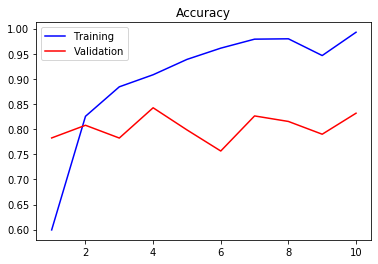

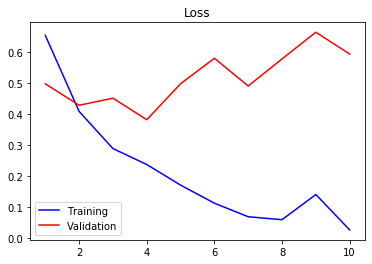

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validation')
plt.title("Loss")
plt.legend()

plt.show()

In [9]:
print(model.evaluate(x_test, y_test))

25000/25000 [==============================] - 17s 696us/step
[0.6321302935361862, 0.8226400017738342]


#### 결과 분석
- 약 82% 정도의 정확도

#### 3장의 FCN(85%)보다 성능이 좋지 않은 이유
- 전체 시퀀스가 아닌 500개의 단어만 입력에 사용했기 때문(정보가 적음)
- SimpleRNN 모델은 텍스트처럼 긴 시퀀스를 처리하는데 적합하지 않기 때문(더 잘 동작하는 순환 층이 있음)

## 6.2.2 LSTM과 GRU 층 이해하기

### SimpleRNN의 문제

- SimpleRNN은 이론적으로 모든 t에서 이전의 모든 타임스텝의 정보를 유지할 수 있지만 **실제로는 모든 정보를 유지할 수 없는 것이 문제임**
- 층이 많은 네트워크에서 나타나는 것과 비슷한 현상인 **그래디언트 소실 문제(vanishing gradient problem)** 때문에 이와 같은 현상이 일어남

- **이러한 SimpleRNN의 문제를 해결하기 위해 고안된 모델이 LSTM과 GRU이며 실전에서 더 자주 쓰이는 순환 층 모델임**

### LSTM

- LSTM(Long Short-Term Memory)은 SimpleRNN에서 정보를 여러 타임 스텝에 걸쳐 나르는 방법이 추가된 모델
- **이전의 정보를 전달해주는 데이터 흐름이 하나 더 추가되어 층이 깊어지더라도 그래디언트가 소실되는 것을 막아줌**

### LSTM의 동작

1. 타임스텝 t에서 추가된 데이터 흐름(`c_t`)이 출력(`output_t`)에 영향을 미침
    
    
    위 과정을 pseudo code로 표현하면 다음과 같음    

~~~
output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)
~~~

2. 다음 타임스텝 t에 영향을 미칠 데이터 흐름(`c_t+1`)의 계산은 총 3개의 변환을 가지며 자신만의 가중치 행렬을 가짐(각각 i, f, k로 표시)


    위 과정을 pseudo code로 표현하면 다음과 같음
    
~~~
i_t = activation(dot(input_t, Wi) + dot(state_t, Ui) + bi)
f_t = activation(dot(input_t, Wf) + dot(state_t, Uf) + bf)
k_t = activation(dot(input_t, Wk) + dot(state_t, Uk) + bk)

c_t+1 = (i_t*k_t) + (c_t*f_t)
~~~


### LSTM의 이해

앞서 살펴본 동작들을 해석하면 다음과 같음

- `i_t와 k_t`는 현재에 대한 정보를 제공하고 이동 트랙을 새로운 정보로 업데이트
- `c_t`와 `f_t`의 곱셈은 관련이 적은 정보를 의도적으로 삭제
- 위와 같은 해석 때문에 `f_t`는 삭제 게이트(forget gate), `i_t`는 입력 게이트(input gate)라고도 부름

하지만 **이러한 해석들은 큰 의미가 없으며** 이유는 다음과 같음

1. 이러한 연산들은 가중치 행렬에 따라 결정되며 가중치는 end-to-end방식으로 학습됨
2. 이는 매 훈련 반복마다 새로 시작되며 하나하나에 특정 목적을 부여하기 어려움

RNN 셀의 사양은 가설 공간을 결정하지만 같은 셀이라도 다른 가중치를 가지는 경우 매우 다른 작업을 수행함

따라서 **RNN셀을 구성하는 연산 조합은 엔지니어링적인 설계가 아니라 가설공간의 제약 조건으로 해석하는 것이 더 좋음**

연구자에게는 RNN셀의 구현 방법 같은 제약 조건의 선택을 엔지니어보다 최적화 알고리즘에 맡기는 것이 더 나아보일 것이고 미래에는 이렇게 네트워크를 만들게 될 것임

요약하면,

1. **LSTM의 구체적인 구조에 대해 이해할 필요가 전혀 없음**
2. **과거 정보를 다시 주입해서 vanishing gradient problem을 해결하는 LSTM의 역할만 기억하면 됨**